# Autoencoders Project for Anomaly Detection + Dimensionality Reduction!!!

Name: Anthony Kevin Oktavius


Let's reconstruct dog faces.

Library Import

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import cv2
import shutil
import zipfile
import os
import zipfile
import gc
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import xml.etree.ElementTree as ET # Parse XML Data.

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14722178174157871839
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13890289664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16825584061162592886
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


If the computer supports GPU, then use GPU. Otherwise, just use CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Preparation

The dataset that is used is the same as for the project Siamese Network for Dogs Dataset.

### Data Training

Dataset Link: https://github.com/GuillaumeMougeot/DogFaceNet/releases/

In [ ]:
! wget https://github.com/GuillaumeMougeot/DogFaceNet/releases/download/dataset/DogFaceNet_Dataset_224_1.zip -O dog_face_net.zip
! unzip ./dog_face_net.zip

Streaming output truncated to the last 5000 lines.
  inflating: after_4_bis/326/326.3.jpg  
  inflating: after_4_bis/326/326.4.jpg  
  inflating: after_4_bis/326/326.5.jpg  
  inflating: after_4_bis/326/326.6.jpg  
  inflating: after_4_bis/326/326.7.jpg  
   creating: after_4_bis/327/
  inflating: after_4_bis/327/327.0.jpg  
  inflating: after_4_bis/327/327.1.jpg  
  inflating: after_4_bis/327/327.2.jpg  
  inflating: after_4_bis/327/327.3.jpg  
  inflating: after_4_bis/327/327.4.jpg  
  inflating: after_4_bis/327/327.5.jpg  
   creating: after_4_bis/328/
  inflating: after_4_bis/328/328.0.jpg  
  inflating: after_4_bis/328/328.1.jpg  
  inflating: after_4_bis/328/328.2.jpg  
  inflating: after_4_bis/328/328.3.jpg  
  inflating: after_4_bis/328/328.4.jpg  
  inflating: after_4_bis/328/328.5.jpg  
  inflating: after_4_bis/328/328.6.jpg  
   creating: after_4_bis/329/
  inflating: after_4_bis/329/329.0.jpg  
  inflating: after_4_bis/329/329.1.jpg  
  inflating: after_4_bis/329/329.2.jpg 

### Data Testing

Get Data from Kaggle.

In [ ]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset

cp: cannot create regular file '/root/.kaggle/': Not a directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
content_directory = "/content/"
zip_path = content_directory + 'stanford-dogs-dataset.zip'
dataset_path = content_directory + 'datasets/'
annotations_directory = dataset_path + 'annotations/'
zip_file = zipfile.ZipFile(zip_path, 'r')
zip_file.extractall(dataset_path)
zip_file.close()

print("Images have been successfully extracted!")

FileNotFoundError: ignored

In [ ]:
# Rename all folders, so all names consist of words only
def split_values(labels, split_char, start_split_index):
  list_labels = []
  for label in labels:
    temp_label = label.split(split_char)
    temp_sliced_labels = temp_label[:][start_split_index:]
    new_string = ""
    for temp_sliced_label in temp_sliced_labels:
      new_string += str(temp_sliced_label) + ' '
    list_labels.append(new_string)
  return list_labels

# Rename Annotations Path
annotations_directory_path = dataset_path + 'annotations/Annotation/'
all_annotations_directory_name = sorted(os.listdir(annotations_directory_path))
first_split_labels = split_values(all_annotations_directory_name, '-', 1)
second_split_labels = split_values(first_split_labels, '_', 0)
currentIndex = 0
for annotation_directory_name in all_annotations_directory_name:
  print("Renaming {} to {}".format(annotations_directory_path + annotation_directory_name, annotations_directory_path + second_split_labels[currentIndex]))
  os.rename(annotations_directory_path + annotation_directory_name, annotations_directory_path + second_split_labels[currentIndex])
  currentIndex += 1
print("All Annotations Directories' name have been fixed! Happy classifying!")

# Rename Image Directory Path
images_directory_path = dataset_path + 'images/Images/'
all_images_directory_name = sorted(os.listdir(images_directory_path))
first_split_labels = split_values(all_images_directory_name, '-', 1)
second_split_labels = split_values(first_split_labels, '_', 0)
currentIndex = 0
for image_directory_name in all_images_directory_name:
  print("Renaming {} to {}".format(images_directory_path + image_directory_name, images_directory_path + second_split_labels[currentIndex]))
  os.rename(images_directory_path + image_directory_name, images_directory_path + second_split_labels[currentIndex])
  currentIndex += 1
print("All Image Directories' name have been fixed! Happy classifying!")

## Data Preprocessing

Prepare the dataset using ImageFolder.

In [ ]:
dogs_folder_datasets = torchvision.datasets.ImageFolder(
    "./after_4_bis/",
)
dogs_folder_datasets

Dataset ImageFolder
    Number of datapoints: 8363
    Root location: ./after_4_bis/

Split into train and validation data

In [ ]:
stratify_targets = dogs_folder_datasets.targets
no_of_unique_targets = np.unique(stratify_targets, return_counts = True)

dog_folder_train_datasets, dog_folder_val_datasets = train_test_split(
    dogs_folder_datasets,
    test_size = 0.2,
    stratify = stratify_targets,
)

print(f"Total train datasets: {len(dog_folder_train_datasets)}")
print(f"Total Validation datasets: {len(dog_folder_val_datasets)}")

Total train datasets: 6690
Total Validation datasets: 1673


There will be several transformations that will be done to this dataset, they are:

* Elastic Transformation (similar to adding some blur, but produces water effects)
* Shear
* Noise

To make life easier, we just use Transforms.Compose, so we can instantly apply distortions to the image.

In [ ]:
def change_hue(image, hue_factor = 0):
  image = image.convert("HSV")
  image = TF.adjust_hue(image, hue_factor = hue_factor)
  image = image.convert("RGB")
  return image

def add_noise(image, noise_factor, mean = 0, std = 2.0, image_size = (224, 224, 3), hue_factor = 0):
  noise = np.random.normal(mean, std, image_size)
  noised_image = image + noise_factor * noise
  noised_image = noised_image.astype(np.uint8)
  noised_image = Image.fromarray(noised_image)
  return noised_image

def clamp_image(image, min = 0, max = 1):
  image = torch.clamp(image, min = min, max = max)
  return image

image_input_transforms = transforms.Compose([
  # transforms.Resize((800,800)),
  transforms.ElasticTransform(alpha = 100.0),
  # transforms.RandomAffine(degrees = 0, shear = 5),
  transforms.ToTensor(),
  # transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                      std=[0.229, 0.224, 0.225]),
  # transforms.Lambda(clamp_image),
])

image_output_transforms = transforms.Compose([
  # transforms.Resize((800,800)),
  transforms.ToTensor(),
  # transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                      std=[0.229, 0.224, 0.225]),
  # transforms.Lambda(clamp_image),              
])

Perform Sample Image Testing

In [ ]:
class DogsAutoencodersDataset(Dataset):
  def __init__(self, image_folder_dataset, image_input_transform, image_output_transforms):
    super(DogsAutoencodersDataset, self).__init__()
    self.image_folder_dataset = image_folder_dataset
    self.image_input_transform = image_input_transform
    self.image_output_transform = image_output_transforms

  def __getitem__(self, index):
    sample_image, _ = self.image_folder_dataset[index]
    
    hue_factor = random.uniform(-0.1, 0.1)
    is_random_horizontal_flip = random.randint(0, 1)
    is_vertical_horizontal_flip = random.randint(0, 1)

    input_image = sample_image.copy()
    output_image = sample_image.copy()

    # input_image = change_hue(input_image, hue_factor)
    # output_image = change_hue(output_image, hue_factor)

    input_image = add_noise(input_image, 0.2)

    if is_random_horizontal_flip:
      input_image = TF.hflip(input_image)
      output_image = TF.hflip(output_image)

    if is_vertical_horizontal_flip:
      input_image = TF.vflip(input_image)
      output_image = TF.vflip(output_image)

    input_image = self.image_input_transform(input_image)
    output_image = self.image_output_transform(output_image)

    return input_image, output_image

  def __len__(self):
    return len(self.image_folder_dataset)
    
dogs_autoencoders_train_dataset = DogsAutoencodersDataset(
    dog_folder_train_datasets,
    image_input_transforms,
    image_output_transforms,
)

dog_autoencoders_val_datasets = DogsAutoencodersDataset(
    dog_folder_val_datasets,
    image_input_transforms,
    image_output_transforms,
)

# Test the function above.
print("Training Dataset Properties:")
sample_input_image, sample_output_image = dogs_autoencoders_train_dataset[0]
print(sample_input_image.shape)
print(sample_output_image.shape)

print("Validation Dataset Properties:")
sample_input_image, sample_output_image = dog_autoencoders_val_datasets[0]
print(sample_input_image.shape)
print(sample_output_image.shape)

Training Dataset Properties:
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
Validation Dataset Properties:
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Make Data Loaders

In [ ]:
dog_autoencoders_train_loader = torch.utils.data.DataLoader(
    dogs_autoencoders_train_dataset,
    batch_size = 16,
    pin_memory = True
)

dog_autoencoders_val_loader = torch.utils.data.DataLoader(
    dog_autoencoders_val_datasets,
    batch_size = 16,
    pin_memory = True
)

Visualize Sample Images

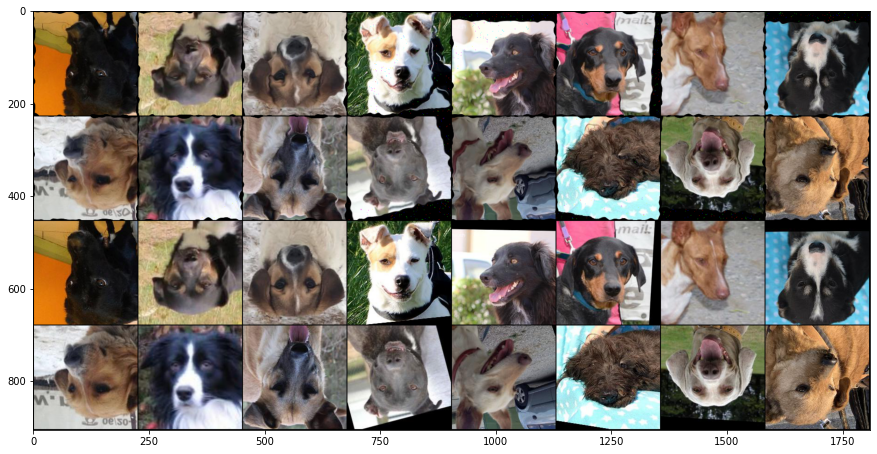

In [ ]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(images_in_batch):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_input_image, sample_output_image = next(iter_loader)

  sample_image_batch = torch.cat(
      [sample_input_image,  sample_output_image], 
      0,
  )

  visualize_pytorch_grid(sample_image_batch)

visualize_dataloader(dog_autoencoders_train_loader, "Dogs Transformed Image")

## Data Modelling

Did you know? Autoencoders is used in Image Segmentation! You can see this project in Image Segmentation using U-Net Architecture.

Below is the architecture that we'll make:

![Autoencoders Architecture](https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/04/29201743/Blog_info_29-04-2020-R-01-1024x438.png)

There are three models that will be made:

* Basic Autoencoders.
* Basic Autoencoders (with Pretrained model for the encoder).
* Variational Autoencoders.

In [ ]:
def save_model(model, optimizer, filename = "model.pth.tar"):
  print("Saving model...")
  checkpoint = {
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)
  print("Finished saving model!")

def forward_propagate_layers(sample_datum, flattened_model_layers, device):
  all_layers_output = []
  with torch.no_grad():
    output = sample_datum
    for layer in flattened_model_layers:
      output = output.to(device)
      output = layer(output)
      all_layers_output.append(output)
      print(f"Layer: {layer}, with output size: {output.shape}")
  return all_layers_output

def load_model(model, optimizer, filename = "model.pth.tar"):
  print("Loading model...")
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Finished loading model!")

def make_one_sample_data(tensor_dataset, data_index):
  sample_datum = tensor_dataset[data_index][0]
  print(f"Your previous sample data: {sample_datum.shape}")
  sample_datum = sample_datum.unsqueeze(0)
  print(f"Your current sample data: {sample_datum.shape}")
  return sample_datum

def flatten_layers_from_model(model, START_FROM_INDEX = 1, filter_layers = [torch.nn.modules.container.Sequential]):
  """
  Use this for pretrained models only.
  
  If you use a model that combines pretrained layers and custom layers, it may throw an error.
  """
  # Get all the model layers, except Sequential Layers, 
  # since we'd like to iterate the layers one by one.
  model_layers = list(model.modules())[START_FROM_INDEX:]
  flattened_model_layers = []

  for index, layer in enumerate(model_layers):
    # print(type(layer))
    # Filter layers, as we don't want to process sequential layers.
    if type(layer) != torch.nn.modules.container.Sequential:
      flattened_model_layers.append(layer)

  return flattened_model_layers

def inspect_model(model):

  print("==========================================================")
  print("Layer Names:")
  non_sequential_layers =  flatten_layers_from_model(model)
  for index, layer in enumerate(non_sequential_layers):
    print(f"{index}: {layer}")
  print("==========================================================")

  print("==========================================================")
  print("Model Weights: ")
  model_weights = model.state_dict()
  layer_names = model_weights.keys()
  for layer_name in layer_names:
    print(f"{layer_name}: {model_weights[layer_name].shape}")
  print("==========================================================")

### Basic Autoencoders

In [ ]:
class BasicAutoencoders(nn.Module):
  def __init__(self):
    super(BasicAutoencoders, self).__init__()
    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Padding (same): [(5 - 1) / 2] = 2
    # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14

    self.encoder_1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    self.encoder_2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    self.encoder_3 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    self.encoder_4 = nn.Sequential(
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )

    self.decoder_1 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
    )
    self.decoder_2 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1), 
    )
    self.decoder_3 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
    )
    self.decoder_4 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 3, padding = 1),
    )

  def forward(self, x):
    x = self.encoder_1(x)
    x = self.encoder_2(x)
    x = self.encoder_3(x)
    x = self.encoder_4(x)
    x = self.decoder_1(x)
    x = self.decoder_2(x)
    x = self.decoder_3(x)
    x = self.decoder_4(x)
    return x

basic_autoencoders_model = BasicAutoencoders().to(device)
basic_autoencoders_model

BasicAutoencoders(
  (encoder_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (decoder_1): Sequential(
    (0): ReLU()
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), p

Inspect the model

In [ ]:
inspect_model(BasicAutoencoders())

Layer Names:
0: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2: ReLU()
3: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5: ReLU()
6: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
8: ReLU()
9: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
11: ReLU()
12: ReLU()
13: Upsample(scale_factor=2.0, mode=nearest)
14: Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15: ReLU()
16: Upsample(scale_factor=2.0, mode=nearest)
17: Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18: ReLU()
19: Upsample(scale_factor=2.0, mode=nearest)
20: Conv2d(64, 32, kernel_size=(3, 3), strid

Test Feedforwarding the image.

In [ ]:
sample_datum = make_one_sample_data(dogs_autoencoders_train_dataset, 0)
basic_autoencoders_layers = flatten_layers_from_model(BasicAutoencoders().to(device))
basic_autoencoders_all_layer_outputs = forward_propagate_layers(
    sample_datum, 
    basic_autoencoders_layers, 
    device
)

Your previous sample data: torch.Size([3, 224, 224])
Your current sample data: torch.Size([1, 3, 224, 224])
Layer: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 224, 224])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 32, 112, 112])
Layer: ReLU(), with output size: torch.Size([1, 32, 112, 112])
Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 64, 112, 112])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 64, 56, 56])
Layer: ReLU(), with output size: torch.Size([1, 64, 56, 56])
Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 128, 56, 56])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 128, 28, 28])
Layer: ReLU()

In [ ]:
cross_entropy_loss_func = nn.MSELoss()

adam_optimizer = optim.Adam(basic_autoencoders_model.parameters(), lr = 0.001)
epochs = 5
loss_history = []

verbose = True
save_model_location = "./drive/MyDrive/basic_autoencoders_cpu.pth.tar"

for epoch in range(epochs):
  # Training Phase
  for train_iteration, (input_image, output_image) in enumerate(dog_autoencoders_train_loader):
    adam_optimizer.zero_grad()

    input_image = input_image.to(device)
    output_image = output_image.to(device)

    prediction_image = basic_autoencoders_model(input_image)
    loss = cross_entropy_loss_func(prediction_image, output_image)

    loss.backward()
    adam_optimizer.step()

    if verbose and train_iteration % 10 == 0 and train_iteration != 0:
      print(f"(Training) Epochs {epoch + 1} / {epochs}, Iteration number: {train_iteration + 1}, loss: {loss.item()}")

  # Validation Phase.
  correct = 0
  total = 0
  total_validation_losses = 0
  total_val_iterations = 1
  with torch.no_grad():
    for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):
      
      input_image = input_image.to(device)
      output_image = output_image.to(device)

      predicted_image_filters_conv2d = basic_autoencoders_model(input_image)

      val_loss = cross_entropy_loss_func(predicted_image_filters_conv2d, input_image)
      
      # Determine the number of pixels.
      total_number_of_pixels = (output_image.size(2) * output_image.size(3)) ** 3

      correct += (predicted_image_filters_conv2d == output_image).sum().item()
      correct /= total_number_of_pixels

      # Get the label size to total variable. 
      total += output_image.size(0)

      if verbose and val_iteration % 10 == 0 and val_iteration != 0:
        print(f"(Validation) Epochs {epoch + 1} / {epochs}, Iteration number: {val_iteration + 1}, Loss: {val_loss}")

      total_val_iterations += 1
      total_validation_losses += val_loss

  avg_val_loss = total_validation_losses / total_val_iterations
  # accuracy = 100 * correct / total
  # accuracy_history.append(accuracy)
  print(f"End Epoch {epoch + 1}, average validation loss: {avg_val_loss}")
  save_model(basic_autoencoders_model, adam_optimizer, filename = save_model_location)

(Training) Epochs 1 / 5, Iteration number: 11, loss: 0.12984217703342438
(Training) Epochs 1 / 5, Iteration number: 21, loss: 0.032846640795469284
(Training) Epochs 1 / 5, Iteration number: 31, loss: 0.025994380936026573
(Training) Epochs 1 / 5, Iteration number: 41, loss: 0.02273055724799633
(Training) Epochs 1 / 5, Iteration number: 51, loss: 0.02223336137831211
(Training) Epochs 1 / 5, Iteration number: 61, loss: 0.0172684695571661
(Training) Epochs 1 / 5, Iteration number: 71, loss: 0.016642391681671143
(Training) Epochs 1 / 5, Iteration number: 81, loss: 0.01798759214580059
(Training) Epochs 1 / 5, Iteration number: 91, loss: 0.014263824559748173
(Training) Epochs 1 / 5, Iteration number: 101, loss: 0.016549747437238693
(Training) Epochs 1 / 5, Iteration number: 111, loss: 0.012599333189427853
(Training) Epochs 1 / 5, Iteration number: 121, loss: 0.012928717769682407
(Training) Epochs 1 / 5, Iteration number: 131, loss: 0.01486267987638712
(Training) Epochs 1 / 5, Iteration number

Load the saved model.

In [ ]:
device_name = "GPU"
directory_path = "./drive/MyDrive"
basic_autoencoders_model = BasicAutoencoders()
basic_autoencoders_model.to(device)
cross_entropy_loss_function = nn.MSELoss()
adam_optimizer = optim.Adam(basic_autoencoders_model.parameters(), lr = 0.001)
basic_autoencoders_model, adam_optimizer = load_model(basic_autoencoders_model, adam_optimizer, f"{directory_path}/.pth.tar")

Visualize Datasets from Validation Data

torch.Size([16, 3, 224, 224])
tensor(1.1291, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0584, device='cuda:0', grad_fn=<MinBackward1>)


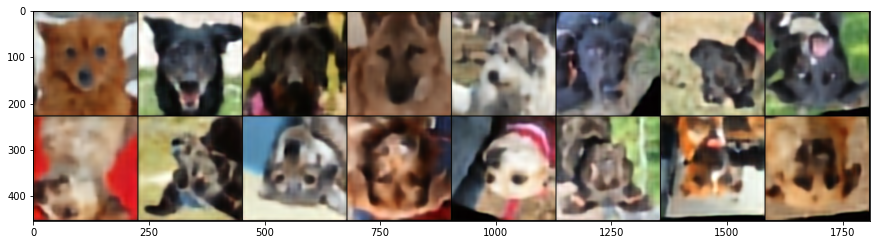

In [ ]:
for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):

  input_image = input_image.to(device)
  output_image = output_image.to(device)

  predicted_images = basic_autoencoders_model(input_image)
  print(predicted_images.shape)
  print(predicted_images.max())
  print(predicted_images.min())

  # predicted_image = get_PIL_image_from_tensor(predicted_image)

  visualize_pytorch_grid(predicted_images.cpu())

  break

### Basic Autoencoders, but with Pretrained Models

Visualize Pretrained Network Architecture.

In [ ]:
print(models.vgg11(pretrained = True))
print(models.regnet_x_16gf(pretrained = True))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_16GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_16GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_16gf-2007eb11.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_16gf-2007eb11.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [ ]:
def turn_off_grad_pretained_model(pretrained_model, is_requires_grad = False):
  for param in pretrained_model.parameters():
    param.requires_grad = is_requires_grad

class PretrainedAutoencoders(nn.Module):
  def __init__(self, pretrained_model):
    super(PretrainedAutoencoders, self).__init__()
    self.pretrained_model = pretrained_model
    self.max_pretrained_layer_index = None # This will be used for Encoder.
    self.flatten_layers_exception = [torch.nn.modules.container.Sequential]
    turn_off_grad_pretained_model(pretrained_model)

  def __flatten_layers_from_pretrained_model__(self):
    # Get all the model layers, except Sequential Layers, 
    # since we'd like to iterate the layers one by one.
    model_layers = list(self.pretrained_model.modules())[1:]
    flattened_model_layers = []

    for layer_index, layer in enumerate(model_layers):
      # print(type(layer))
      if type(layer) not in self.flatten_layers_exception:
        flattened_model_layers.append(layer)

      if self.max_pretrained_layer_index is not None and \
        layer_index == self.max_pretrained_layer_index:
        break

    return flattened_model_layers

  def print_filtered_pretrained_model_layers(self):
    print("==========================================================")
    print("Pretrained Layer Names:")
    layers = self.__flatten_layers_from_pretrained_model__()
    for index, layer in enumerate(layers):
      print(f"{index}: {layer}")
    print("==========================================================")

  def print_style_transfer_model_weights(self):
    print("==========================================================")
    print("Model Weights: ")
    model_weights = self.style_transfer_model.state_dict()
    layer_names = model_weights.keys()
    for layer_name in layer_names:
      print(f"{layer_name}: {model_weights[layer_name].shape}")
    print("==========================================================")

  def forward(self, x):
    raise NotImplementedError("Forward Propagation hasn't been implemented for this model! Please write the code for this first!")

class VGG11Autoencoders(PretrainedAutoencoders):
  def __init__(self):
    super(VGG11Autoencoders, self).__init__(
        pretrained_model = models.vgg11(pretrained = True)
    )
    self.max_pretrained_layer_index = 14

    self.encoder = nn.Sequential(
        *self.pretrained_model.features
    )

    self.decoder_1 = nn.Sequential(
        nn.Upsample(scale_factor = 2),
        nn.ReLU(),
    )

    self.decoder_2 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
    )

    self.decoder_3 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.Upsample(scale_factor = 2),
        nn.ReLU(),
    )
    self.decoder_4 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
    )

    self.decoder_5 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.Upsample(scale_factor = 2),
        nn.ReLU(),
    )
    self.decoder_6 = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
    )
    self.decoder_7 = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
    )
    self.decoder_8 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1),
    )
    self.decoder_9 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
    )
    self.output = nn.Conv2d(64, 3, kernel_size = 3, stride = 1, padding = 1)

  # def forward_test(self, x):
  #   def print_feature_map_size(layer, x):
  #     print(f"Layer: {layer}, with output size: {output.shape}")
  #   x = self.encoder(x)
  #   x = self.decoder_1(x)
  #   x = self.decoder_2(x)
  #   x = self.decoder_3(x)
  #   x = self.decoder_4(x)
  #   x = self.decoder_5(x)
  #   x = self.decoder_6(x)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder_1(x)
    x = self.decoder_2(x)
    x = self.decoder_3(x)
    x = self.decoder_4(x)
    x = self.decoder_5(x)
    x = self.decoder_6(x)
    x = self.decoder_7(x)
    x = self.decoder_8(x)
    x = self.decoder_9(x)
    x = self.output(x)
    return x

class RegNetX16Autoencoders(PretrainedAutoencoders):
  def __init__(self):
    super(RegNetX16Autoencoders, self).__init__(
        pretrained_model = models.regnet_x_16gf(pretrained = True)
    )
    self.max_pretrained_layer_index = 60
    self.flatten_layers_exception = [
        torch.nn.modules.container.Sequential,
        torchvision.ops.Conv2dNormActivation,
        torchvision.ops.SqueezeExcitation,
        torchvision.models.regnet.SimpleStemIN,
        torchvision.models.regnet.AnyStage,
        torchvision.models.regnet.ResBottleneckBlock,
        torchvision.models.regnet.BottleneckTransform,
        torchvision.ops.misc.Conv2dNormActivation,
    ]

  def forward(self, x):
    pass


vgg11_autoencoders = VGG11Autoencoders().to(device)
regnet_x16_autoencoders = RegNetX16Autoencoders().to(device)

print(vgg11_autoencoders)
print(regnet_x16_autoencoders)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_16GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_16GF_Weights.DEFAULT` to get the most up-to-date wei

VGG11Autoencoders(
  (pretrained_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): M

In [ ]:
vgg11_autoencoders.print_filtered_pretrained_model_layers()

Pretrained Layer Names:
0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1: ReLU(inplace=True)
2: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4: ReLU(inplace=True)
5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
6: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7: ReLU(inplace=True)
8: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9: ReLU(inplace=True)
10: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
11: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12: ReLU(inplace=True)
13: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
regnet_x16_autoencoders.print_filtered_pretrained_model_layers()

Pretrained Layer Names:
0: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
1: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU(inplace=True)
3: Conv2d(32, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
4: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5: Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
6: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
7: ReLU(inplace=True)
8: Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
9: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
10: ReLU(inplace=True)
11: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
12: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
13: ReLU(inplace=True)
14: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
15: BatchNorm2d(256, eps=

In [ ]:
mse_loss_func = nn.MSELoss()

adam_optimizer = optim.Adam(vgg11_autoencoders.parameters(), lr = 0.0001)
epochs = 5
loss_history = []

verbose = True
save_model_location = "./drive/MyDrive/vgg11_autoencoders.pth.tar"

for epoch in range(epochs):
  # Training Phase
  for train_iteration, (input_image, output_image) in enumerate(dog_autoencoders_train_loader):
    adam_optimizer.zero_grad()

    input_image = input_image.to(device)
    output_image = output_image.to(device)

    prediction_image = vgg11_autoencoders(input_image)
    loss = mse_loss_func(prediction_image, output_image)

    loss.backward()
    adam_optimizer.step()

    if verbose and train_iteration % 10 == 0 and train_iteration != 0:
      print(f"(Training) Epochs {epoch + 1} / {epochs}, Iteration number: {train_iteration + 1}, loss: {loss.item()}")

  # Validation Phase.
  correct = 0
  total = 0
  total_validation_losses = 0
  total_val_iterations = 1
  with torch.no_grad():
    for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):
      
      input_image = input_image.to(device)
      output_image = output_image.to(device)

      predicted_image_filters_conv2d = vgg11_autoencoders(input_image)

      val_loss = mse_loss_func(predicted_image_filters_conv2d, input_image)
      
      # Determine the number of pixels.
      total_number_of_pixels = (output_image.size(2) * output_image.size(3)) ** 3

      correct += (predicted_image_filters_conv2d == output_image).sum().item()
      correct /= total_number_of_pixels

      # Get the label size to total variable. 
      total += output_image.size(0)

      if verbose and val_iteration % 10 == 0 and val_iteration != 0:
        print(f"(Validation) Epochs {epoch + 1} / {epochs}, Iteration number: {val_iteration + 1}, Loss: {val_loss}")

      total_val_iterations += 1
      total_validation_losses += val_loss

  avg_val_loss = total_validation_losses / total_val_iterations
  # accuracy = 100 * correct / total
  # accuracy_history.append(accuracy)
  print(f"End Epoch {epoch + 1}, average validation loss: {avg_val_loss}")
  save_model(vgg11_autoencoders, adam_optimizer, filename = save_model_location)

(Training) Epochs 1 / 5, Iteration number: 11, loss: 0.11772859841585159
(Training) Epochs 1 / 5, Iteration number: 21, loss: 0.07319137454032898
(Training) Epochs 1 / 5, Iteration number: 31, loss: 0.05931190401315689
(Training) Epochs 1 / 5, Iteration number: 41, loss: 0.055026162415742874
(Training) Epochs 1 / 5, Iteration number: 51, loss: 0.0478033572435379
(Training) Epochs 1 / 5, Iteration number: 61, loss: 0.04506169259548187
(Training) Epochs 1 / 5, Iteration number: 71, loss: 0.044566936790943146
(Training) Epochs 1 / 5, Iteration number: 81, loss: 0.04093555361032486
(Training) Epochs 1 / 5, Iteration number: 91, loss: 0.03726698458194733
(Training) Epochs 1 / 5, Iteration number: 101, loss: 0.04468446224927902
(Training) Epochs 1 / 5, Iteration number: 111, loss: 0.0326036736369133
(Training) Epochs 1 / 5, Iteration number: 121, loss: 0.03683435544371605
(Training) Epochs 1 / 5, Iteration number: 131, loss: 0.04061503708362579
(Training) Epochs 1 / 5, Iteration number: 141,

torch.Size([16, 3, 224, 224])
tensor(0.9522, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0176, device='cuda:0', grad_fn=<MinBackward1>)


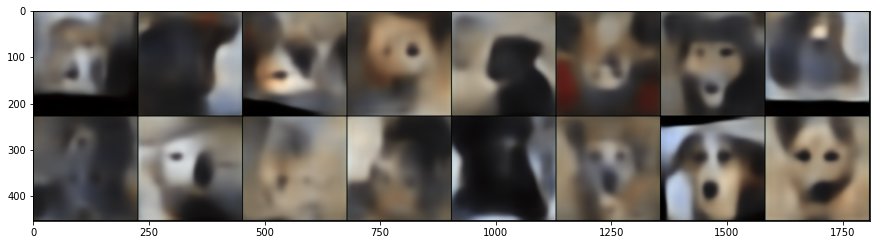

In [ ]:
for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):

  input_image = input_image.to(device)
  output_image = output_image.to(device)

  predicted_images = vgg11_autoencoders(input_image)
  print(predicted_images.shape)
  print(predicted_images.max())
  print(predicted_images.min())

  # predicted_image = get_PIL_image_from_tensor(predicted_image)

  visualize_pytorch_grid(predicted_images.cpu())

  break

### Variational Autoencoders.

Define KL Divergence Loss Function

In [ ]:
class KLDivergenceLoss(nn.Module):
  def __init__(self, target_image):
    super(KLDivergenceLoss, self).__init__()
    self.target_image = target_image
  
  def forward(self, mean, log_var, generated_image):
    mse_loss = F.mse_loss(generated_image, self.target_image, reduction = "sum")
    kl_divergence = 0.5 * torch.sum(log_var.exp() + (mean ** 2) - 1 - log_var)
    return mse_loss + kl_divergence

sample_generated_image = make_one_sample_data(
    dogs_autoencoders_train_dataset, 0
)

sample_target_image = make_one_sample_data(
    dogs_autoencoders_train_dataset, 1
)

mean = torch.mean(sample_generated_image)
log_var = torch.std(sample_target_image)

kl_divergence_loss = KLDivergenceLoss(sample_target_image)

print(kl_divergence_loss(mean, log_var, sample_generated_image))

Your previous sample data: torch.Size([3, 224, 224])
Your current sample data: torch.Size([1, 3, 224, 224])
Your previous sample data: torch.Size([3, 224, 224])
Your current sample data: torch.Size([1, 3, 224, 224])
tensor(27462.6895)


Make the model.

In [ ]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, latent_dimension):
    super(VariationalAutoencoder, self).__init__()
    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Padding (same): [(5 - 1) / 2] = 2
    # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14

    # 224
    self.encoder_1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    # 112
    self.encoder_2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    # 56
    self.encoder_3 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    # 28
    self.encoder_4 = nn.Sequential(
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), 
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
    )
    # 14

    self.mean_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(256 * 14 * 14, latent_dimension),
    )

    self.log_variance_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(256 * 14 * 14, latent_dimension),
    )

    self.decoder_1 = nn.Sequential(
        nn.Linear(latent_dimension, 256 * 14 * 14),
        nn.Unflatten(-1, (256, 14, 14)),
        nn.ReLU(),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
    )
    self.decoder_2 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1), 
    )
    self.decoder_3 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
    )
    self.decoder_4 = nn.Sequential(
        nn.ReLU(),
        nn.Upsample(scale_factor = 2), 
        nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 3, padding = 1),
    )

  def reparameterization_trick(self, mean, log_var,):
    standard_deviation = torch.exp(log_var / 2) # Raise to an exponential, for numerical stability
    epsilon = torch.randn_like(standard_deviation) # Sample from normal distribution, with size as the same shape as standard deviation
    return mean + standard_deviation * epsilon

  def forward_in_encoder(self, x):
    x = self.encoder_1(x)
    x = self.encoder_2(x)
    x = self.encoder_3(x)
    x = self.encoder_4(x)
    mean = self.mean_layer(x)
    log_var = self.log_variance_layer(x)
    return mean, log_var
    
  def forward_in_decoder(self, x):
    x = self.decoder_1(x)
    x = self.decoder_2(x)
    x = self.decoder_3(x)
    x = self.decoder_4(x)
    return x
    
  def forward(self, x):
    mean, log_var = self.forward_in_encoder(x)
    z = self.reparameterization_trick(mean, log_var)
    z = self.forward_in_decoder(z)
    return z, mean, log_var

variational_autoencoder = VariationalAutoencoder(
    latent_dimension = 500
).to(device)
print(variational_autoencoder)

VariationalAutoencoder(
  (encoder_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (encoder_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (mean_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=500, bias=True)
  )
  (log_varia

Test the Model.

In [ ]:
sample_datum = make_one_sample_data(dogs_autoencoders_train_dataset, 0)
variational_autoencoders_layers = flatten_layers_from_model(VariationalAutoencoder(
    latent_dimension = 500
).to(device))

basic_autoencoders_all_layer_outputs = forward_propagate_layers(
    sample_datum, 
    variational_autoencoders_layers, 
    device
)


Your previous sample data: torch.Size([3, 224, 224])
Your current sample data: torch.Size([1, 3, 224, 224])
Layer: Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 224, 224])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 32, 112, 112])
Layer: ReLU(), with output size: torch.Size([1, 32, 112, 112])
Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 64, 112, 112])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 64, 56, 56])
Layer: ReLU(), with output size: torch.Size([1, 64, 56, 56])
Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 128, 56, 56])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 128, 28, 28])
Layer: ReLU()

RuntimeError: ignored

Training a Model.

In [ ]:
adam_optimizer = optim.Adam(variational_autoencoder.parameters(), lr = 0.001)
epochs = 10
loss_history = []

verbose = True
save_model_location = "./drive/MyDrive/variational_autoencoders.pth.tar"

for epoch in range(epochs):
  # Training Phase
  for train_iteration, (input_image, output_image) in enumerate(dog_autoencoders_train_loader):
    adam_optimizer.zero_grad()

    input_image = input_image.to(device)
    output_image = output_image.to(device)

    prediction_image, mean, log_var = variational_autoencoder(input_image)
    kl_divergence_func = KLDivergenceLoss(output_image)
    loss = kl_divergence_func(mean, log_var, prediction_image)

    loss.backward()
    adam_optimizer.step()

    if verbose and train_iteration % 10 == 0 and train_iteration != 0:
      print(f"(Training) Epochs {epoch + 1} / {epochs}, Iteration number: {train_iteration + 1}, loss: {loss.item()}")

  # Validation Phase.
  correct = 0
  total = 0
  total_validation_losses = 0
  total_val_iterations = 1
  with torch.no_grad():
    for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):
      
      input_image = input_image.to(device)
      output_image = output_image.to(device)

      predicted_image_filters_conv2d, mean, log_var = variational_autoencoder(input_image)

      kl_divergence_func = KLDivergenceLoss(output_image)
      val_loss = kl_divergence_func(mean, log_var, predicted_image_filters_conv2d)
      
      # Determine the number of pixels.
      total_number_of_pixels = (output_image.size(2) * output_image.size(3)) ** 3

      correct += (predicted_image_filters_conv2d == output_image).sum().item()
      correct /= total_number_of_pixels

      # Get the label size to total variable. 
      total += output_image.size(0)

      if verbose and val_iteration % 10 == 0 and val_iteration != 0:
        print(f"(Validation) Epochs {epoch + 1} / {epochs}, Iteration number: {val_iteration + 1}, Loss: {val_loss}")

      total_val_iterations += 1
      total_validation_losses += val_loss

  avg_val_loss = total_validation_losses / total_val_iterations
  # accuracy = 100 * correct / total
  # accuracy_history.append(accuracy)
  print(f"End Epoch {epoch + 1}, average validation loss: {avg_val_loss}")
  save_model(variational_autoencoder, adam_optimizer, filename = save_model_location)

(Training) Epochs 1 / 5, Iteration number: 11, loss: 66927.6796875
(Training) Epochs 1 / 5, Iteration number: 21, loss: 62180.48828125
(Training) Epochs 1 / 5, Iteration number: 31, loss: 53868.05859375
(Training) Epochs 1 / 5, Iteration number: 41, loss: 55417.02734375
(Training) Epochs 1 / 5, Iteration number: 51, loss: 56328.55859375
(Training) Epochs 1 / 5, Iteration number: 61, loss: 67799.8125
(Training) Epochs 1 / 5, Iteration number: 71, loss: 53531.203125
(Training) Epochs 1 / 5, Iteration number: 81, loss: 53098.96484375
(Training) Epochs 1 / 5, Iteration number: 91, loss: 59020.78125
(Training) Epochs 1 / 5, Iteration number: 101, loss: 56055.60546875
(Training) Epochs 1 / 5, Iteration number: 111, loss: 49731.234375
(Training) Epochs 1 / 5, Iteration number: 121, loss: 46519.8671875
(Training) Epochs 1 / 5, Iteration number: 131, loss: 51456.79296875
(Training) Epochs 1 / 5, Iteration number: 141, loss: 60343.078125
(Training) Epochs 1 / 5, Iteration number: 151, loss: 4970

Visualize some of the images from validation dataset.

torch.Size([16, 3, 224, 224])
tensor(1.2412, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0875, device='cuda:0', grad_fn=<MinBackward1>)


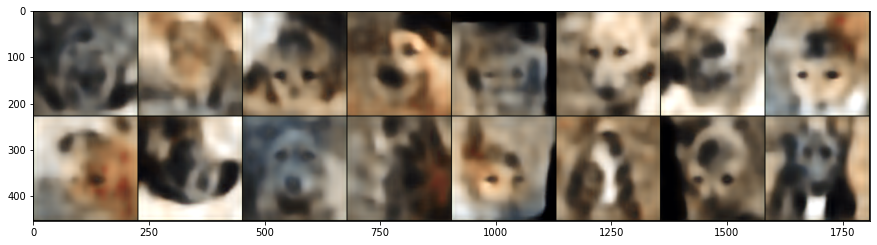

In [ ]:
for val_iteration, (input_image, output_image) in enumerate(dog_autoencoders_val_loader):

  input_image = input_image.to(device)
  output_image = output_image.to(device)

  predicted_images, mean, log_var = variational_autoencoder(input_image)
  print(predicted_images.shape)
  print(predicted_images.max())
  print(predicted_images.min())

  # predicted_image = get_PIL_image_from_tensor(predicted_image)

  visualize_pytorch_grid(predicted_images.cpu())

  break